In [3]:
import json
def analyze_json(filepath):
    # 读取JSON文件
    with open(filepath, 'r', encoding='utf-8') as file:
        data = json.load(file)

    # 初始化计数器
    total_checks = 0
    total_results = 0
    total_yes = 0

    # 遍历每个元素，累计数值
    for item in data:
        # 统计 checks 的键值对数量
        total_checks += len(item.get('checks_once', {}))
        total_checks += len(item.get('checks_range', {}))
        total_checks += len(item.get('checks_periodic', {}))
        
        # 统计 results 的键值对数量
        results_once = item.get('results_once', {})
        results_range = item.get('results_range', {})
        results_periodic = item.get('results_periodic', {})
        
        total_results += len(results_once)
        total_results += len(results_range)
        total_results += len(results_periodic)

        # 累加值为 'yes' 的 results 的数量
        total_yes += sum(1 for key in results_once if results_once[key] == 'yes')
        total_yes += sum(1 for key in results_range if results_range.get(key, '') == 'yes')
        total_yes += sum(1 for key in results_periodic if results_periodic.get(key, '') == 'yes')

    # 输出结果
    print("Total checks key-value pairs:", total_checks)
    print("Total results key-value pairs:", total_results)
    print("Total 'yes' occurrences in results:", total_yes)

# 用实际的文件路径替换 'yourfile.json'
analyze_json('/home/yuhao/THREADING-THE-NEEDLE/Evalution/results/Qwen2-72B-Instruct_maxlen32000.json')


Total checks key-value pairs: 8215
Total results key-value pairs: 5189
Total 'yes' occurrences in results: 1428


In [3]:
import json
import os
import csv
import re

def calculate_completion_rate(type_to_block, total_number):
    identifiers = set(type_to_block.keys())
    expected_identifiers = set(range(1, total_number + 1))
    missing_identifiers = expected_identifiers - identifiers
    completion_rate = (len(expected_identifiers) - len(missing_identifiers)) / len(expected_identifiers)
    return completion_rate * 100
def parse_blocks(output_blocks, type):
    type_to_block = {}
    pattern = rf"{type} (\d+)"  # 假设类型后的数字仍有用，例如标识ID或序号
    for block in output_blocks:
        match = re.search(pattern, block)
        if match:
            identifier = int(match.group(1))  # 获取类型后的数字
            if identifier not in type_to_block or type_to_block[identifier] is None:
                type_to_block[identifier] = block

    return type_to_block

def analyze_json(filepath):
    # 初始化计数器
    total_checks = 0
    total_results = 0
    total_yes = 0
    total_word_count = 0
    word_count_entries = 0
    completion_rate = 0 
    
    # 读取JSON文件
    with open(filepath, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    # 遍历每个元素，累计数值
    for item in data:
        # 统计 checks 的键值对数量
        total_checks += len(item.get('checks_once', {}))
        total_checks += len(item.get('checks_range', {}))
        total_checks += len(item.get('checks_periodic', {}))
        
        # 统计 results 的键值对数量
        results_once = item.get('results_once', {})
        results_range = item.get('results_range', {})
        results_periodic = item.get('results_periodic', {})
        
        total_results += len(results_once)
        total_results += len(results_range)
        total_results += len(results_periodic)

        # 累加值为 'yes' 的 results 的数量
        total_yes += sum(1 for key in results_once if results_once[key] == 'yes')
        total_yes += sum(1 for key in results_range if results_range.get(key, '') == 'yes')
        total_yes += sum(1 for key in results_periodic if results_periodic.get(key, '') == 'yes')
        
        # 累加符合条件的 word_count
        if 'output_blocks' in item and len(item['output_blocks']) > 40:
            if 'word_count' in item and item['word_count'] > 2000:
                total_word_count += item['word_count']
                word_count_entries += 1
        
        checks_block = parse_blocks(item['output_blocks'], item['type'])
        completion_rate += calculate_completion_rate(checks_block, item['number'])


    # 计算比率
    ratio_results_checks = total_results / total_checks if total_checks > 0 else None
    ratio_yes_results = total_yes / total_results if total_results > 0 else None
    ratio_yes_checks = total_yes / total_checks if total_checks > 0 else None
    completion_rate /= len(data) 

    # 计算平均 word_count
    average_word_count = total_word_count / word_count_entries if word_count_entries > 0 else None

    return [total_checks, total_results, total_yes, ratio_results_checks, ratio_yes_results, ratio_yes_checks, average_word_count,completion_rate]

def process_directory(directory_path):
    results = []
    # 遍历目录中的所有文件
    for filename in os.listdir(directory_path):
        if filename.endswith(".json"):
            filepath = os.path.join(directory_path, filename)
            result = analyze_json(filepath)
            results.append([filename] + result)
    sorted_results = sorted(results, key=lambda x: x[0])
    # 将结果保存到 CSV 文件
    with open('static.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Filename', 'Total Checks', 'Total Results', 'Total Yes', 'Ratio Results/Checks', 'Ratio Yes/Results', 'Ratio Yes/Checks', 'Average Word Count','CR'])
        writer.writerows(sorted_results)

# 用实际的文件夹路径替换 'path_to_your_directory'
process_directory('/home/yuhao/THREADING-THE-NEEDLE/Evalution/results')


## draw section 2

In [6]:
import json

def load_and_count_keys(json_file_path):
    # 初始化键值为1到100的计数字典，同时统计键出现的总次数和值为 'yes' 的次数
    key_count = {str(i): {'total': 0, 'yes': 0} for i in range(1, 52)}

    # 加载 JSON 文件
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    # 遍历 JSON 文件中的每个元素
    for element in data:
        # 处理总键次数
        for key_category in ['checks_once', 'checks_range', 'checks_periodic']:
            if key_category in element:
                for key in element[key_category]:
                    if key in key_count:
                        key_count[key]['total'] += 1

        # 处理值为 'yes' 的次数
        for result_category in ['results_once', 'results_range', 'results_periodic']:
            if result_category in element:
                for key, value in element[result_category].items():
                    if key in key_count and value == "yes":
                        key_count[key]['yes'] += 1

    # 打印统计结果
    for key, counts in key_count.items():
        if counts['total'] > 0:  # 防止除以零
            print(f"Key '{key}': Total count = {counts['total']}, 'Yes' count = {counts['yes']}, "
                  f"Ratio of 'Yes' = {counts['yes'] / counts['total']:.2f}")

# 假设 JSON 文件位于你的计算机上的以下路径

# 假设 JSON 文件位于你的计算机上的以下路径
json_file_path = '/home/yuhao/THREADING-THE-NEEDLE/Evalution/results/Meta-Llama-3.1-8B-Instruct_maxlen16000.json'
load_and_count_keys(json_file_path)


Key '1': Total count = 34, 'Yes' count = 8, Ratio of 'Yes' = 0.24
Key '2': Total count = 38, 'Yes' count = 2, Ratio of 'Yes' = 0.05
Key '3': Total count = 45, 'Yes' count = 18, Ratio of 'Yes' = 0.40
Key '4': Total count = 65, 'Yes' count = 11, Ratio of 'Yes' = 0.17
Key '5': Total count = 47, 'Yes' count = 14, Ratio of 'Yes' = 0.30
Key '6': Total count = 52, 'Yes' count = 10, Ratio of 'Yes' = 0.19
Key '7': Total count = 87, 'Yes' count = 24, Ratio of 'Yes' = 0.28
Key '8': Total count = 41, 'Yes' count = 9, Ratio of 'Yes' = 0.22
Key '9': Total count = 47, 'Yes' count = 15, Ratio of 'Yes' = 0.32
Key '10': Total count = 54, 'Yes' count = 15, Ratio of 'Yes' = 0.28
Key '11': Total count = 75, 'Yes' count = 11, Ratio of 'Yes' = 0.15
Key '12': Total count = 66, 'Yes' count = 22, Ratio of 'Yes' = 0.33
Key '13': Total count = 83, 'Yes' count = 21, Ratio of 'Yes' = 0.25
Key '14': Total count = 73, 'Yes' count = 18, Ratio of 'Yes' = 0.25
Key '15': Total count = 87, 'Yes' count = 16, Ratio of 'Yes'

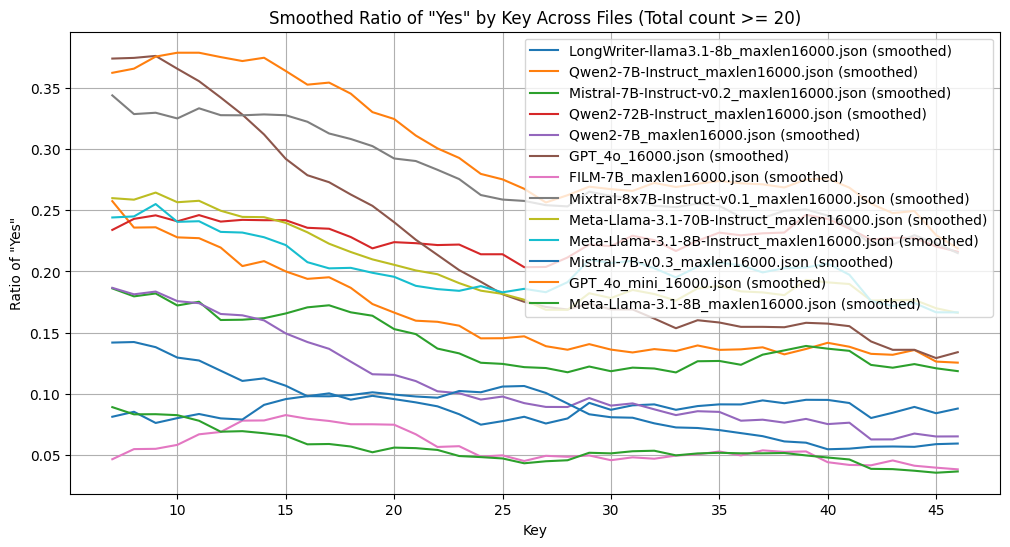

In [39]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

def load_and_count_keys(json_file_path):
    key_count = {str(i): {'total': 0, 'yes': 0} for i in range(1, 53)}

    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for element in data:
        for key_category in ['checks_once', 'checks_range', 'checks_periodic']:
            if key_category in element:
                for key in element[key_category]:
                    if key in key_count:
                        key_count[key]['total'] += 1
        for result_category in ['results_once', 'results_range', 'results_periodic']:
            if result_category in element:
                for key, value in element[result_category].items():
                    if key in key_count and value == "yes":
                        key_count[key]['yes'] += 1

    return key_count





def plot_yes_ratios(all_key_counts, window_size=13):
    plt.figure(figsize=(12, 6))

    for file_name, key_count in all_key_counts.items():
        x_vals = []
        y_vals = []
        for key, counts in key_count.items():
            if counts['total'] >= 20:
                ratio = counts['yes'] / counts['total'] if counts['total'] > 0 else 0
                x_vals.append(int(key))
                y_vals.append(ratio)

        # Calculate moving average
        if len(y_vals) >= window_size:
            weights = np.ones(window_size) / window_size
            y_smooth = np.convolve(y_vals, weights, mode='valid')

            # Explicitly adjust x_vals to match the exact length of y_smooth
            # Start index for x_vals is (window_size - 1) // 2 to center the window
            start_index = (window_size - 1) // 2
            x_smooth = x_vals[start_index:start_index + len(y_smooth)]

            plt.plot(x_smooth, y_smooth, label=f'{file_name} (smoothed)')

    plt.title('Smoothed Ratio of "Yes" by Key Across Files (Total count >= 20)')
    plt.xlabel('Key')
    plt.ylabel('Ratio of "Yes"')
    plt.grid(True)
    plt.legend()
    plt.show()



def process_files_in_directory(directory_path):
    all_key_counts = {}
    for file in os.listdir(directory_path):
        if "16000" in file and file.endswith('.json'):
            file_path = os.path.join(directory_path, file)
            key_counts = load_and_count_keys(file_path)
            all_key_counts[file] = key_counts

    plot_yes_ratios(all_key_counts)

# Usage
directory_path = '/home/yuhao/THREADING-THE-NEEDLE/Evalution/results'
process_files_in_directory(directory_path)


In [9]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

def load_and_count_keys(json_file_path):
    key_count = {str(i): {'total': 0, 'yes': 0} for i in range(1, 300)}

    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for element in data:
        for key_category in ['checks_once', 'checks_range', 'checks_periodic']:
            if key_category in element:
                for key in element[key_category]:
                    if key in key_count:
                        key_count[key]['total'] += 1
        for result_category in ['results_once', 'results_range', 'results_periodic']:
            if result_category in element:
                for key, value in element[result_category].items():
                    if key in key_count and value == "yes":
                        key_count[key]['yes'] += 1

    return key_count





def plot_yes_ratios(all_key_counts, window_size=20):
    plt.figure(figsize=(12, 6))

    for file_name, key_count in all_key_counts.items():
        x_vals = []
        y_vals = []
        for key, counts in key_count.items():
            if counts['total'] >= 30:
                ratio = counts['yes'] / counts['total'] if counts['total'] > 0 else 0
                x_vals.append(int(key))
                y_vals.append(ratio)

        # Calculate moving average
        if len(y_vals) >= window_size:
            weights = np.ones(window_size) / window_size
            y_smooth = np.convolve(y_vals, weights, mode='valid')

            # Explicitly adjust x_vals to match the exact length of y_smooth
            # Start index for x_vals is (window_size - 1) // 2 to center the window
            start_index = (window_size - 1) // 2
            x_smooth = x_vals[start_index:start_index + len(y_smooth)]

            plt.plot(x_smooth, y_smooth, label=f'{file_name} (smoothed)')

    plt.title('Smoothed Ratio of "Yes" by Key Across Files (Total count >= 20)')
    plt.xlabel('Key')
    plt.ylabel('Ratio of "Yes"')
    plt.grid(True)
    plt.legend()
    plt.show()



def process_files_in_directory(directory_path):
    all_key_counts = {}
    for file in os.listdir(directory_path):
        if "32000" in file and file.endswith('.json'):
            file_path = os.path.join(directory_path, file)
            key_counts = load_and_count_keys(file_path)
            all_key_counts[file] = key_counts

    plot_yes_ratios(all_key_counts)

# Usage
directory_path = '/home/yuhao/THREADING-THE-NEEDLE/Evalution/results'
process_files_in_directory(directory_path)


KeyError: 'once'

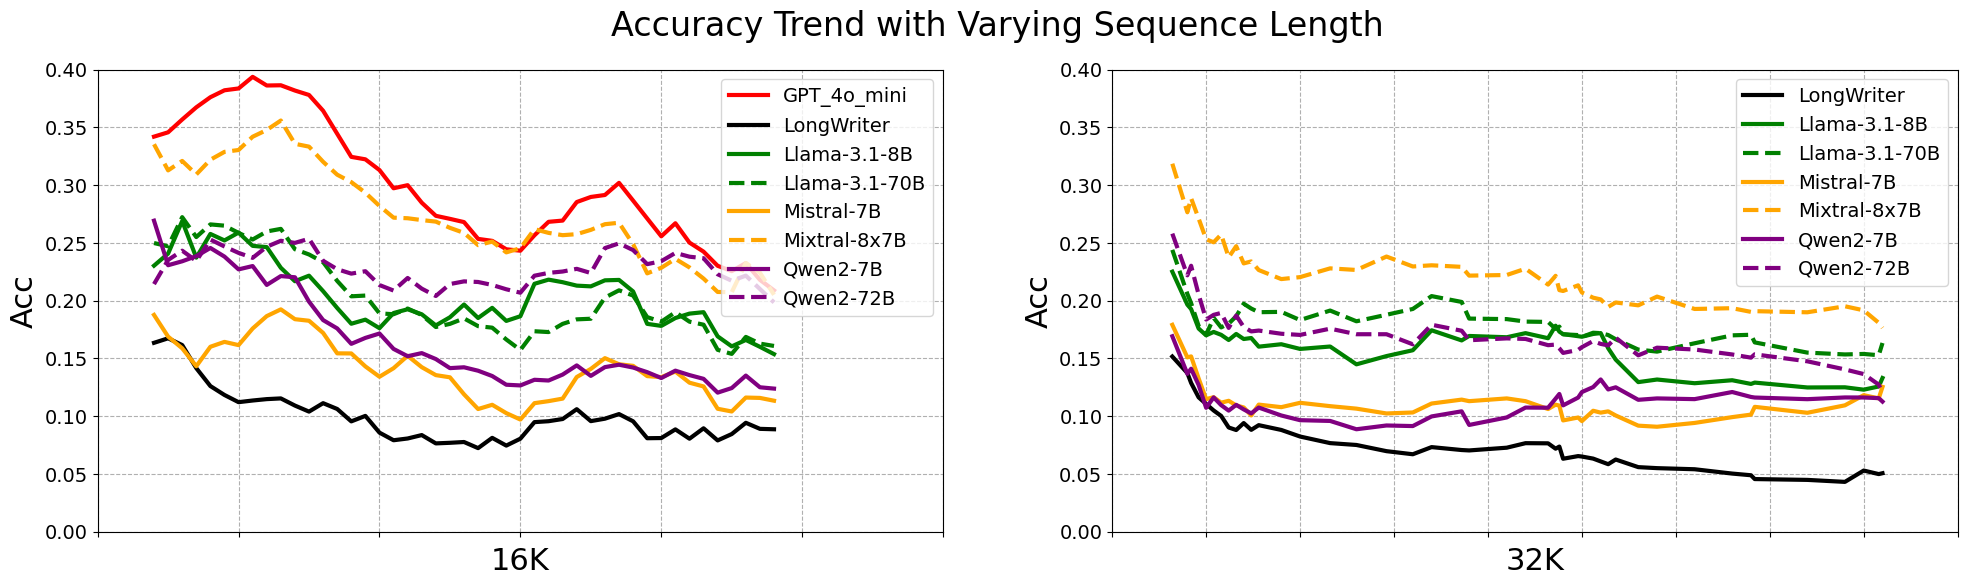

In [14]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

def load_and_count_keys_1(json_file_path):
    key_count = {str(i): {'total': 0, 'yes': 0} for i in range(1, 53)}
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for element in data:
        for key_category in ['checks_once', 'checks_range', 'checks_periodic']:
            if key_category in element:
                for key in element[key_category]:
                    if key in key_count:
                        key_count[key]['total'] += 1
        for result_category in ['results_once', 'results_range', 'results_periodic']:
            if result_category in element:
                for key, value in element[result_category].items():
                    if key in key_count and value == "yes":
                        key_count[key]['yes'] += 1
    return key_count

def load_and_count_keys_2(json_file_path):
    key_count = {str(i): {'total': 0, 'yes': 0} for i in range(1, 301)}
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for element in data:
        for key_category in ['checks_once', 'checks_range', 'checks_periodic']:
            if key_category in element:
                for key in element[key_category]:
                    if key in key_count:
                        key_count[key]['total'] += 1
        for result_category in ['results_once', 'results_range', 'results_periodic']:
            if result_category in element:
                for key, value in element[result_category].items():
                    if key in key_count and value == "yes":
                        key_count[key]['yes'] += 1
    return key_count
# def plot_yes_ratios(file_configs, window_size=8):
  

#     for config in file_configs:
#         file_path = config['path']
#         color = config['color']
#         linestyle = config['linestyle']
#         label = config['label']

#         key_count = load_and_count_keys(file_path)
#         x_vals = []
#         y_vals = []
#         for key, counts in key_count.items():
#             if counts['total'] >= 30:
#                 ratio = counts['yes'] / counts['total'] if counts['total'] > 0 else 0
#                 x_vals.append(int(key))
#                 y_vals.append(ratio)

#         if len(y_vals) >= window_size:
#             weights = np.ones(window_size) / window_size
#             y_smooth = np.convolve(y_vals, weights, mode='valid')
#             start_index = (window_size - 1) // 2
#             x_smooth = x_vals[start_index:start_index + len(y_smooth)]

#             plt.plot(x_smooth, y_smooth, color=color, linestyle=linestyle, label=label)

#     plt.title('Accuracy Trend with Varying Sequence Length')
#     plt.xlabel('16K')
#     plt.ylabel('ACC')  # Hide x-axis labels｜
#     plt.grid(True)
#     plt.legend()
#     plt.show()

def plot_yes_ratios_1(ax, file_configs, window_size=8):
    for config in file_configs:
        file_path = config['path']
        color = config['color']
        linestyle = config['linestyle']
        label = config['label']

        key_count = load_and_count_keys_1(file_path)
        x_vals = []
        y_vals = []
        for key, counts in key_count.items():
            if counts['total'] >= 30:
                ratio = counts['yes'] / counts['total'] if counts['total'] > 0 else 0
                x_vals.append(int(key))
                y_vals.append(ratio)

        if len(y_vals) >= window_size:
            weights = np.ones(window_size) / window_size
            y_smooth = np.convolve(y_vals, weights, mode='valid')
            start_index = (window_size - 1) // 2
            x_smooth = x_vals[start_index:start_index + len(y_smooth)]

            ax.plot(x_smooth, y_smooth, color=color, linestyle=linestyle,  linewidth=3,label=label)
    
    ax.set_ylim(0, 0.4) 
    ax.set_xlabel('16K', fontsize=22)
    ax.set_ylabel('Acc', fontsize=22)
    ax.grid(True, linestyle='--') 
    ax.legend(fontsize=14)
    ax.set_xticks(ax.get_xticks())  # Set x-tick labels to empty strings to keep the structure
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xticklabels(['']*len(ax.get_xticks()))  # Hide x-axis labels but keep ticks

def plot_yes_ratios_2(ax, file_configs, window_size=15):
    for config in file_configs:
        file_path = config['path']
        color = config['color']
        linestyle = config['linestyle']
        label = config['label']

        key_count = load_and_count_keys_2(file_path)
        x_vals = []
        y_vals = []
        for key, counts in key_count.items():
            if counts['total'] >= 30:
                ratio = counts['yes'] / counts['total'] if counts['total'] > 0 else 0
                x_vals.append(int(key))
                y_vals.append(ratio)

        if len(y_vals) >= window_size:
            weights = np.ones(window_size) / window_size
            y_smooth = np.convolve(y_vals, weights, mode='valid')
            start_index = (window_size - 1) // 2
            x_smooth = x_vals[start_index:start_index + len(y_smooth)]

            ax.plot(x_smooth, y_smooth, color=color, linestyle=linestyle, linewidth=3,label=label)
    
    ax.set_ylim(0, 0.4) 
    ax.set_xlabel('32K', fontsize=22)
    ax.set_ylabel('Acc', fontsize=22)
    ax.grid(True, linestyle='--') 
    ax.legend(fontsize=14)
    ax.set_xticks(ax.get_xticks())  # Set x-tick labels to empty strings to keep the structure
    ax.tick_params(axis='y', labelsize=14)
    ax.set_xticklabels(['']*len(ax.get_xticks()))  # Hide x-axis labels but keep ticks
   

fig, axes = plt.subplots(1, 2, figsize=(24, 6))

# Main title for the figure
fig.suptitle('Accuracy Trend with Varying Sequence Length', fontsize=24)

# Configuration for each file, specifying the file path, color, line style, and label for the plot
file_configs_1 = [
   
    {'path': 'GPT_4o_mini_16000.json', 'color': 'red', 'linestyle': '-', 'label': 'GPT_4o_mini'},
    {'path': 'LongWriter-llama3.1-8b_maxlen16000.json', 'color': 'black', 'linestyle': '-', 'label': 'LongWriter'},
    {'path': 'Meta-Llama-3.1-8B-Instruct_maxlen16000.json', 'color': 'green', 'linestyle': '-', 'label': 'Llama-3.1-8B'},
    {'path': 'Meta-Llama-3.1-70B-Instruct_maxlen16000.json', 'color': 'green', 'linestyle': '--', 'label': 'Llama-3.1-70B'},
    {'path': 'Mistral-7B-Instruct-v0.2_maxlen16000.json', 'color': 'orange', 'linestyle': '-', 'label': 'Mistral-7B'},
    {'path': 'Mixtral-8x7B-Instruct-v0.1_maxlen16000.json', 'color': 'orange', 'linestyle': '--', 'label': 'Mixtral-8x7B'},
    {'path': 'Qwen2-7B-Instruct_maxlen16000.json', 'color': 'purple', 'linestyle': '-', 'label': 'Qwen2-7B'},
    {'path': 'Qwen2-72B-Instruct_maxlen16000.json', 'color': 'purple', 'linestyle': '--', 'label': 'Qwen2-72B'},

]
file_configs_2 = [
   
    {'path': 'LongWriter-llama3.1-8b_maxlen32000.json', 'color': 'black', 'linestyle': '-', 'label': 'LongWriter'},
    {'path': 'Meta-Llama-3.1-8B-Instruct_maxlen32000.json', 'color': 'green', 'linestyle': '-', 'label': 'Llama-3.1-8B'},
    {'path': 'Meta-Llama-3.1-70B-Instruct_maxlen32000.json', 'color': 'green', 'linestyle': '--', 'label': 'Llama-3.1-70B'},
    {'path': 'Mistral-7B-Instruct-v0.2_maxlen32000.json', 'color': 'orange', 'linestyle': '-', 'label': 'Mistral-7B'},
    {'path': 'Mixtral-8x7B-Instruct-v0.1_maxlen32000.json', 'color': 'orange', 'linestyle': '--', 'label': 'Mixtral-8x7B'},
    {'path': 'Qwen2-7B-Instruct_maxlen32000.json', 'color': 'purple', 'linestyle': '-', 'label': 'Qwen2-7B'},
    {'path': 'Qwen2-72B-Instruct_maxlen32000.json', 'color': 'purple', 'linestyle': '--', 'label': 'Qwen2-72B'},

]


plot_yes_ratios_1(axes[0], file_configs_1)
plot_yes_ratios_2(axes[1], file_configs_2)
plt.show()
fig.savefig('combined_plot.pdf', dpi=300, bbox_inches='tight')  # Adjust filename and options as needed


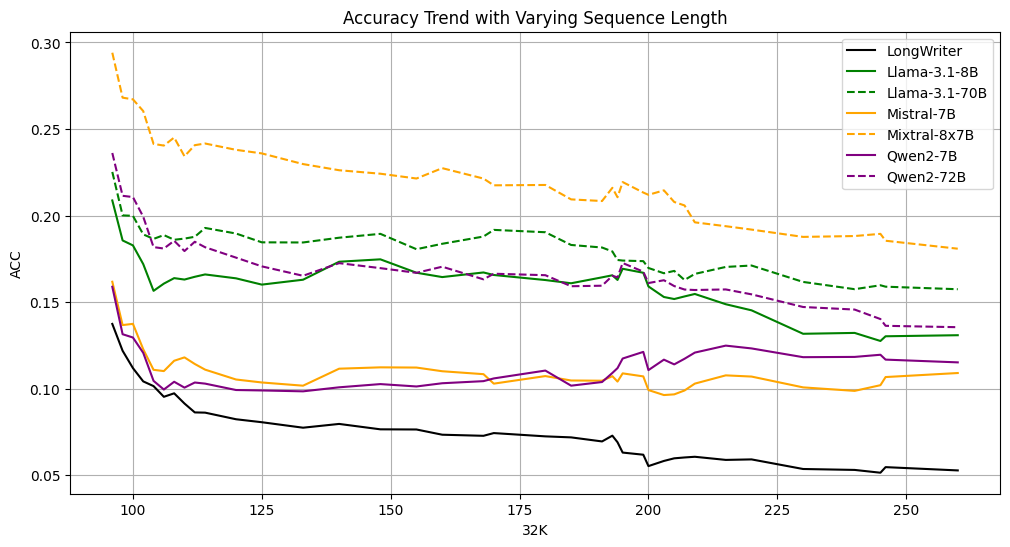

In [4]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

def load_and_count_keys(json_file_path):
    key_count = {str(i): {'total': 0, 'yes': 0} for i in range(1, 300)}
    with open(json_file_path, 'r') as file:
        data = json.load(file)

    for element in data:
        for key_category in ['checks_once', 'checks_range', 'checks_periodic']:
            if key_category in element:
                for key in element[key_category]:
                    if key in key_count:
                        key_count[key]['total'] += 1
        for result_category in ['results_once', 'results_range', 'results_periodic']:
            if result_category in element:
                for key, value in element[result_category].items():
                    if key in key_count and value == "yes":
                        key_count[key]['yes'] += 1
    return key_count

def plot_yes_ratios(file_configs, window_size=20):
    plt.figure(figsize=(12, 6))

    for config in file_configs:
        file_path = config['path']
        color = config['color']
        linestyle = config['linestyle']
        label = config['label']

        key_count = load_and_count_keys(file_path)
        x_vals = []
        y_vals = []
        for key, counts in key_count.items():
            if counts['total'] >= 30:
                ratio = counts['yes'] / counts['total'] if counts['total'] > 0 else 0
                x_vals.append(int(key))
                y_vals.append(ratio)

        if len(y_vals) >= window_size:
            weights = np.ones(window_size) / window_size
            y_smooth = np.convolve(y_vals, weights, mode='valid')
            start_index = (window_size - 1) // 2
            x_smooth = x_vals[start_index:start_index + len(y_smooth)]

            plt.plot(x_smooth, y_smooth, color=color, linestyle=linestyle, label=label)

    plt.title('Accuracy Trend with Varying Sequence Length')
    plt.xlabel('32K')
    plt.ylabel('ACC')
    plt.grid(True)
    plt.legend()
    plt.show()

# Configuration for each file, specifying the file path, color, line style, and label for the plot
file_configs = [
   
    {'path': 'LongWriter-llama3.1-8b_maxlen32000.json', 'color': 'black', 'linestyle': '-', 'label': 'LongWriter'},
    {'path': 'Meta-Llama-3.1-8B-Instruct_maxlen32000.json', 'color': 'green', 'linestyle': '-', 'label': 'Llama-3.1-8B'},
    {'path': 'Meta-Llama-3.1-70B-Instruct_maxlen32000.json', 'color': 'green', 'linestyle': '--', 'label': 'Llama-3.1-70B'},
    {'path': 'Mistral-7B-Instruct-v0.2_maxlen32000.json', 'color': 'orange', 'linestyle': '-', 'label': 'Mistral-7B'},
    {'path': 'Mixtral-8x7B-Instruct-v0.1_maxlen32000.json', 'color': 'orange', 'linestyle': '--', 'label': 'Mixtral-8x7B'},
    {'path': 'Qwen2-7B-Instruct_maxlen32000.json', 'color': 'purple', 'linestyle': '-', 'label': 'Qwen2-7B'},
    {'path': 'Qwen2-72B-Instruct_maxlen32000.json', 'color': 'purple', 'linestyle': '--', 'label': 'Qwen2-72B'},

]

plot_yes_ratios(file_configs)


## 三种 STI

Processed /home/yuhao/THREADING-THE-NEEDLE/Evalution/results/GPT_4o_mini_16000.json: {'once': 0.4065540194572453, 'range': 0.3328025477707006, 'periodic': 0.1738985313751669}
Processed /home/yuhao/THREADING-THE-NEEDLE/Evalution/results/Meta-Llama-3.1-8B-Instruct_maxlen16000.json: {'once': 0.2887864823348694, 'range': 0.3105095541401274, 'periodic': 0.13684913217623498}
Processed /home/yuhao/THREADING-THE-NEEDLE/Evalution/results/Meta-Llama-3.1-70B-Instruct_maxlen16000.json: {'once': 0.32462877624167946, 'range': 0.23805732484076433, 'periodic': 0.12583444592790388}
Processed /home/yuhao/THREADING-THE-NEEDLE/Evalution/results/Mistral-7B-Instruct-v0.2_maxlen16000.json: {'once': 0.2713773681515617, 'range': 0.2157643312101911, 'periodic': 0.0937917222963952}
Processed /home/yuhao/THREADING-THE-NEEDLE/Evalution/results/Mixtral-8x7B-Instruct-v0.1_maxlen16000.json: {'once': 0.3635432667690732, 'range': 0.32245222929936307, 'periodic': 0.2082777036048064}
Processed /home/yuhao/THREADING-THE-N

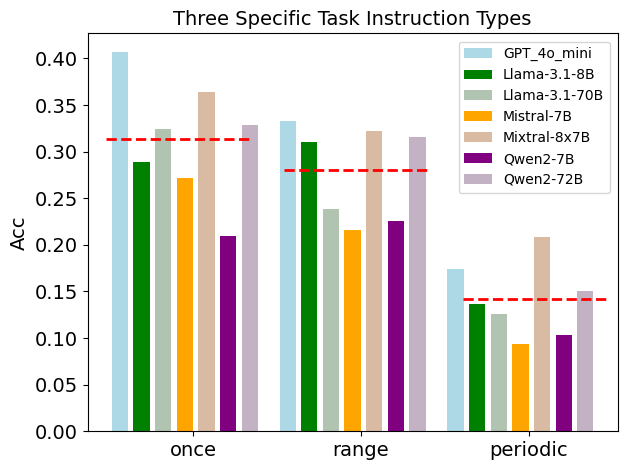

In [9]:
import json
import os
import csv
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm  # Import colormap support


def analyze_json(filepath):
    stats = {
        'once': {'checks': 0, 'yes': 0},
        'range': {'checks': 0, 'yes': 0},
        'periodic': {'checks': 0, 'yes': 0}
    }
    
    with open(filepath, 'r', encoding='utf-8') as file:
        data = json.load(file)
    
    for item in data:
        # 统计 checks
        stats['once']['checks'] += len(item.get('checks_once', {}))
        stats['range']['checks'] += len(item.get('checks_range', {}))
        stats['periodic']['checks'] += len(item.get('checks_periodic', {}))
        
        # 统计 'yes'
        stats['once']['yes'] += sum(1 for key in item.get('results_once', {}) if item['results_once'][key] == 'yes')
        stats['range']['yes'] += sum(1 for key in item.get('results_range', {}) if item['results_range'].get(key, '') == 'yes')
        stats['periodic']['yes'] += sum(1 for key in item.get('results_periodic', {}) if item['results_periodic'].get(key, '') == 'yes')

    # 计算比率
    ratios = {
        'once': stats['once']['yes'] / stats['once']['checks'] if stats['once']['checks'] > 0 else 0,
        'range': stats['range']['yes'] / stats['range']['checks'] if stats['range']['checks'] > 0 else 0,
        'periodic': stats['periodic']['yes'] / stats['periodic']['checks'] if stats['periodic']['checks'] > 0 else 0
    }
    
    print(f"Processed {filepath}: {ratios}")  # 调试输出
    return ratios

def process_directory(directory_path, file_configs):
    results = {}
    for config in file_configs:
        filepath = os.path.join(directory_path, config['path'])
        if os.path.exists(filepath):
            stats = analyze_json(filepath)
            results[config['label']] = {'results': stats, 'color': config['color']}
    return results

def plot_ratios(results):
    #plt.rcParams.update({'font.size': 14})
    types = ['once', 'range', 'periodic']
    labels = list(results.keys())
    data = {t: [results[label]['results'][t] for label in labels] for t in types}

    colors = [config['color'] for config in file_configs if config['label'] in results]
    hatches = [config['hatch'] for config in file_configs if config['label'] in results]  # 获取填充样式列表

    width = 0.15  # 柱状图的宽度
    gap_between_files = 0.05  # 柱状图之间的间隔
    gap_between_groups = 0.15  # 类别之间的间隔

    fig, ax = plt.subplots()
    num_labels = len(labels)
    x_base = np.arange(len(types)) * (num_labels * width + num_labels * gap_between_files + gap_between_groups)

    for i, type in enumerate(types):
        for j, label in enumerate(labels):
            offsets = x_base[i] + j * (width + gap_between_files)
            ax.bar(offsets, data[type][j], width, label=label if i == 0 else "", color=colors[j], hatch=hatches[j])

        average = np.mean(data[type])
        # 调整xmin和xmax以确保红线完全覆盖，包括第一根和最后一根柱子的边缘
        start_x = (x_base[i] - width / 2) / (x_base[-1] + num_labels * width + (num_labels - 1) * gap_between_files + gap_between_groups)
        start_x = start_x+0.05
        
        end_x = (x_base[i] + num_labels * width + (num_labels - 1) * gap_between_files + gap_between_groups - width / 2) / (x_base[-1] + num_labels * width + (num_labels - 1) * gap_between_files + gap_between_groups)
        ax.axhline(y=average, color='red', linestyle='--', linewidth=2, xmin=start_x, xmax=end_x)
        print(start_x)

     # Set x-tick labels to empty strings to keep the structure
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel('Acc', fontsize=14)
    ax.set_title('Three Specific Task Instruction Types', fontsize=14)
    ax.set_xticks(x_base + (num_labels * width + (num_labels - 1) * gap_between_files) / 2)
    ax.set_xticklabels(types, fontsize=14)
    ax.legend(loc=(0.7, 0.6),fontsize=10)  # 这里的坐标是归一化的，(0.5, 0.5) 表示中心


    plt.tight_layout()
    plt.savefig('/home/yuhao/THREADING-THE-NEEDLE/three.pdf', format='pdf')  # 指定保存路径和文件名

    plt.show()

# 配置和文件目录
# file_configs = [
#     {'path': 'GPT_4o_mini_16000.json', 'color': '#ADD8E6', 'label': 'GPT_4o_mini', 'hatch': ''},
#     {'path': 'Meta-Llama-3.1-8B-Instruct_maxlen16000.json', 'color': 'green', 'label': 'Llama-3.1-8B', 'hatch': ''},
#     {'path': 'Meta-Llama-3.1-70B-Instruct_maxlen16000.json', 'color': 'green', 'label': 'Llama-3.1-70B', 'hatch':'////'},
#     {'path': 'Mistral-7B-Instruct-v0.2_maxlen16000.json', 'color': 'orange', 'label': 'Mistral-7B', 'hatch': ''},
#     {'path': 'Mixtral-8x7B-Instruct-v0.1_maxlen16000.json', 'color': 'orange', 'label': 'Mixtral-8x7B', 'hatch':'////'},
#     {'path': 'Qwen2-7B-Instruct_maxlen16000.json', 'color': 'purple', 'label': 'Qwen2-7B', 'hatch': ''},
#     {'path': 'Qwen2-72B-Instruct_maxlen16000.json', 'color': 'purple', 'label': 'Qwen2-72B', 'hatch': '////'},
# ]
file_configs = [
    {'path': 'GPT_4o_mini_16000.json', 'color': '#ADD8E6', 'label': 'GPT_4o_mini', 'hatch': ''},
    {'path': 'Meta-Llama-3.1-8B-Instruct_maxlen16000.json', 'color': 'green', 'label': 'Llama-3.1-8B', 'hatch': ''},
    {'path': 'Meta-Llama-3.1-70B-Instruct_maxlen16000.json', 'color': '#B0C4B1', 'label': 'Llama-3.1-70B', 'hatch':''},
    {'path': 'Mistral-7B-Instruct-v0.2_maxlen16000.json', 'color': 'orange', 'label': 'Mistral-7B', 'hatch': ''},
    {'path': 'Mixtral-8x7B-Instruct-v0.1_maxlen16000.json', 'color': '#D8BBA2', 'label': 'Mixtral-8x7B', 'hatch':''},
    {'path': 'Qwen2-7B-Instruct_maxlen16000.json', 'color': 'purple', 'label': 'Qwen2-7B', 'hatch': ''},
    {'path': 'Qwen2-72B-Instruct_maxlen16000.json', 'color': '#C3B1C4', 'label': 'Qwen2-72B', 'hatch': ''},
]
directory_path = '/home/yuhao/THREADING-THE-NEEDLE/Evalution/results'
results = process_directory(directory_path, file_configs)
plot_ratios(results)


## compare with ruler

/tmp/ipykernel_760544/2198732057.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(model_names, rotation=45, ha='right')
/tmp/ipykernel_760544/2198732057.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(model_names, rotation=45, ha='right')


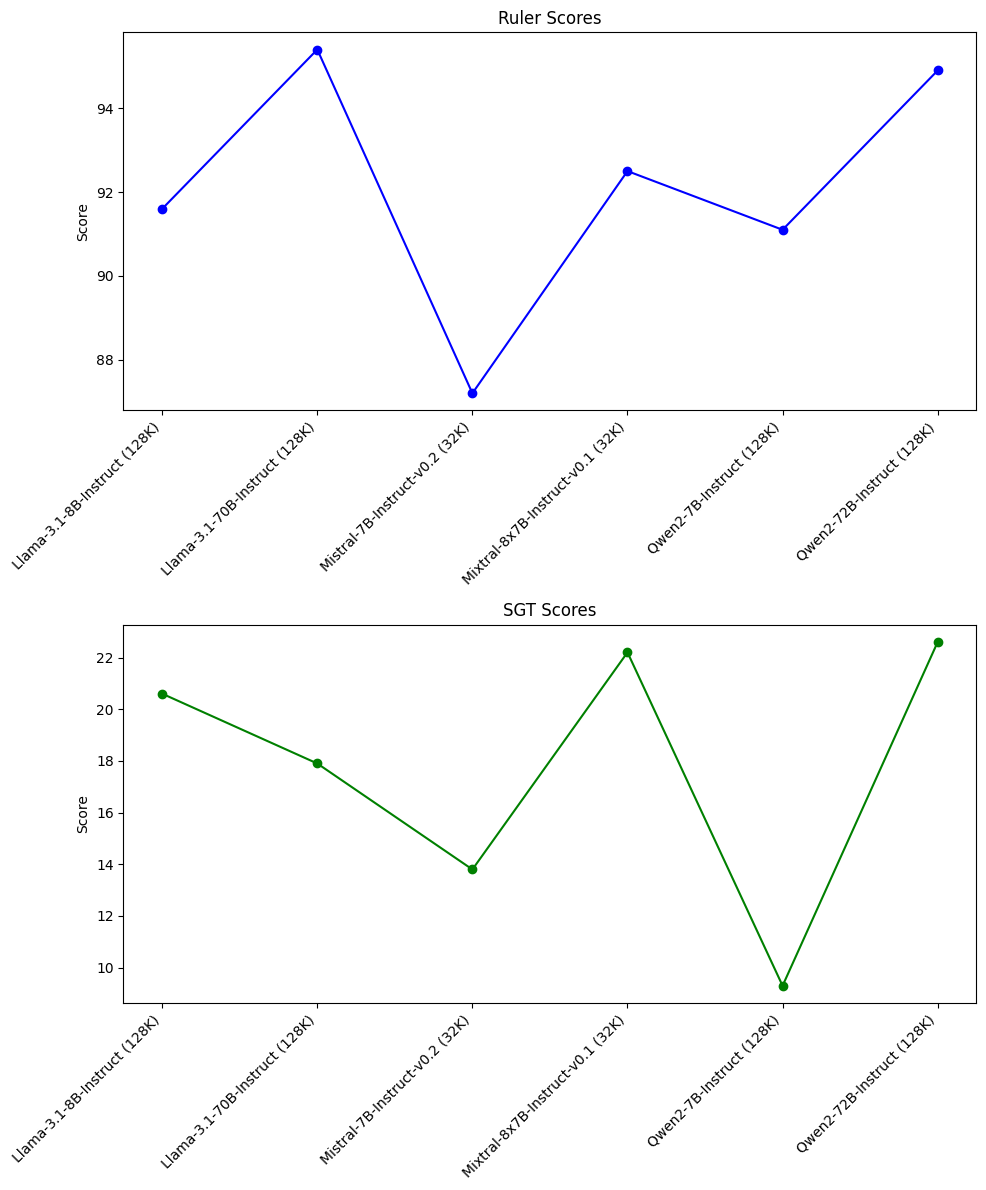

In [8]:
import matplotlib.pyplot as plt

# Model names and corresponding scores
model_names = [
    "Llama-3.1-8B-Instruct (128K)",
    "Llama-3.1-70B-Instruct (128K)",
    "Mistral-7B-Instruct-v0.2 (32K)",
    "Mixtral-8x7B-Instruct-v0.1 (32K)",
    "Qwen2-7B-Instruct (128K)",
    "Qwen2-72B-Instruct (128K)"
]
ruler = [91.6, 95.4, 87.2, 92.5, 91.1, 94.9]
SGT = [20.6, 17.9, 13.8, 22.2, 9.3, 22.6]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# First subplot for Ruler scores
ax1.plot(model_names, ruler, marker='o', linestyle='-', color='blue')
ax1.set_title('Ruler Scores')
ax1.set_ylabel('Score')
ax1.set_xticklabels(model_names, rotation=45, ha='right')

# Second subplot for SGT scores
ax2.plot(model_names, SGT, marker='o', linestyle='-', color='green')
ax2.set_title('SGT Scores')
ax2.set_ylabel('Score')
ax2.set_xticklabels(model_names, rotation=45, ha='right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
